In [99]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import os
import random
from astropy.io import fits
from astropy.coordinates import SkyCoord
from read_cats import GetSDSSCat
import matplotlib.pyplot as plt
import cPickle as pickle
import gzip
import healpy as hp

import numpy as np
import astropy.constants as const

from IPython.display import display, Math, Latex


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_path = '/Volumes/LACIE_SHARE/Data/'
fmap = data_path + 'PlanckDR2/HFI_SkyMap_353-field-IQU_2048_R2.02_full.fits' 
fmask = '/Users/fbianchini/Downloads/HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

In [4]:
mask = hp.reorder(fits.open(fmask)[1].data['GAL040'], n2r=True) # Planck GAL mask

In [5]:
planck = hp.reorder(fits.open(fmap)[1].data['I_STOKES'], n2r=True) # Planck 353 GHz


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


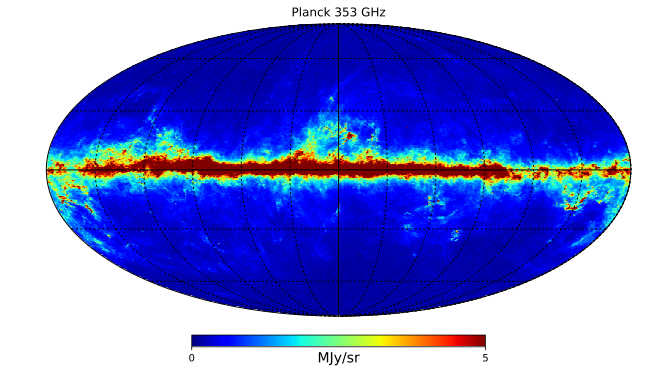

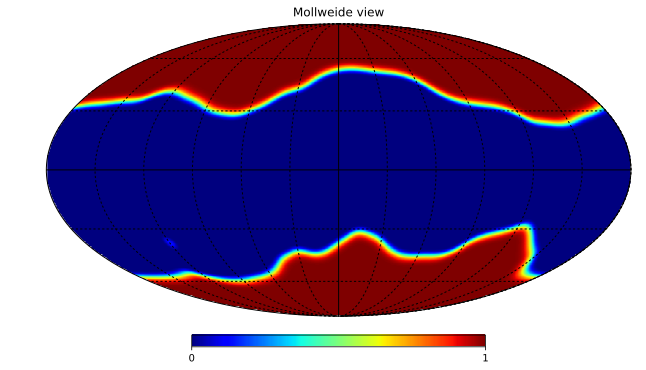

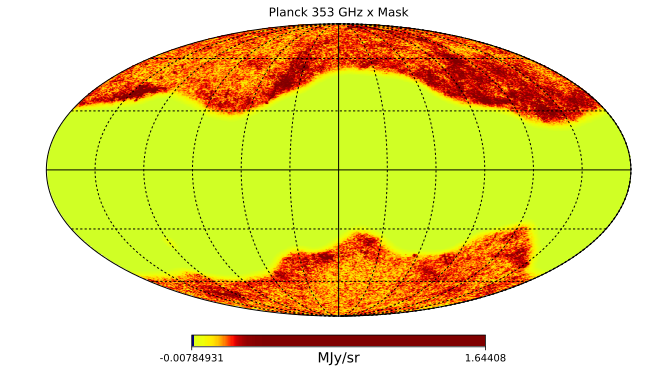

In [50]:
hp.mollview(Kcmb2MJysr(353,planck), min=0, max=5, title='Planck 353 GHz', unit='MJy/sr')
hp.graticule()
hp.mollview(mask)
hp.graticule()
hp.mollview(Kcmb2MJysr(353,mask*planck), norm='hist', title='Planck 353 GHz x Mask' , unit='MJy/sr')
hp.graticule()

In [145]:
def GetClTot(pixmap, beam=0.,mask=None, lmax=None):
    """
    Extract power spectrum from map and deconvolve for Masking, Pixel Window, Beam
    """
    nside = hp.npix2nside(pixmap.size)
    if mask is None:
        mask = np.ones_like(pixmap)
        fsky = 1.
    else:
        assert hp.isnpixok(mask.size)
        fsky = np.mean(mask**2)
    
    cl = hp.anafast(pixmap*mask, lmax=lmax)
    
    if lmax is None:
        lmax = cl.size - 1 
    
    cl /= hp.pixwin(nside)[:lmax+1]**2 # Pixel window funct
    cl /= hp.gauss_beam(np.deg2rad(beam/60.), lmax=lmax)**2
    cl /= fsky # Masking effect
    
    return cl
    
def filter_highpass_lowpass_1d(reclen, lmin, dl):
    # central_freq = samp_freq/float(reclen)
    l = np.arange(reclen)#/2+1) * central_freq
    filt = np.ones(reclen)
    filt[l<lmin-dl/2] = 0.0

    window_for_transition_to_zero = (lmin-dl/2 <= l) * (l <= lmin+dl/2)
    ind=np.where(window_for_transition_to_zero==True)[0]
    reclen_transition_window = len(filt[window_for_transition_to_zero])
    filt[window_for_transition_to_zero] = (1. - np.cos( np.pi* np.arange(reclen_transition_window) /(reclen_transition_window-1))) /2.0

    return filt
        
def GetFl(pixmap, fwhm, mask=None, lmax=None, lmin=300, dl=100):
    if lmax is None:
        lmax = 3.*hp.npix2nside(pixmap.size) - 1.
    fwhm_rad = np.deg2rad(fwhm/60.)
    sigma = fwhm_rad/np.sqrt(8.*np.log(2))
    Bl = hp.gauss_beam(fwhm_rad, lmax=lmax)
    Bl_tilde = 2.*np.pi*sigma**2*Bl
    Cl_tot = GetClTot(pixmap, beam=fwhm, mask=mask, lmax=lmax)
    ell = np.arange(lmax+1)
    return filter_highpass_lowpass_1d(ell.size, lmin=lmin, dl=dl)  * Bl_tilde / (Cl_tot * np.sum((2.*ell+1)*Bl_tilde**2/(4.*np.pi*Cl_tot)))

def FilterMap(pixmap, fwhm, mask=None, lmax=None):
    if mask is None:
        mask = np.ones_like(pixmap)
    else:
        assert hp.isnpixok(mask.size)
    Fl = GetFl(pixmap, fwhm, mask=mask, lmax=lmax)
    alm = hp.map2alm(pixmap*mask, lmax=lmax)
    return hp.alm2map(hp.almxfl(alm, Fl), hp.npix2nside(pixmap.size), lmax=lmax), Fl

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def Kcmb2MJysr(nu, cmb, T_cmb=2.725):
    if nu == 353:
        return 287.450 * cmb
    elif nu == 217:
        return  483.690 * cmb
    
def Sky2Hpx(sky1, sky2, nside, coord='G', nest=False, rad=False):
	"""
	Converts sky coordinates, i.e. (RA,DEC), to Healpix pixel at a given resolution nside.
	By default, it rotates from EQ -> GAL
	Parameters
	----------
	sky1 : array-like
		First coordinate, it can be RA, LON, ...
	sky2 : array-like
		Second coordinate, it can be DEC, LAT, ...
		
	nside : int
		Resolution of the Healpix pixelization scheme
	coord : str 'C','E' or 'G' [def]
		Coordinate system of the output. If coord='C', *no* rotation is applied
	nest : bool [def=False]
		If True, nested pixelation scheme is considered for the output pixels
	rad : bool [def=False]
		If True, input coordinates are expressed in radians, otherwise in degree
	Returns
	-------
	ipix : array-like
		Pixel indices corresponding to (sky1,sky2) coordinates
	"""
	sky1, sky2 = np.asarray(sky1), np.asarray(sky2)

	if rad == False: # deg -> rad
		theta = np.deg2rad(90.-sky2) 
		phi   = np.deg2rad(sky1) 
	else: 
		theta = np.pi/2. - sky2
		phi   = sky1 	     

	# Apply rotation if needed (default EQ -> GAL)
	r = hp.Rotator(coord=['C',coord], deg=False)
	theta, phi = r(theta, phi)

	npix = hp.nside2npix(nside)

	return hp.ang2pix(nside, theta, phi, nest=nest) # Converting galaxy coordinates -> pixel 

In [9]:
planck_filt, fl = FilterMap(planck, 4.94, mask=mask)

/Users/fbianchini/anaconda/lib/python2.7/site-packages/healpy/sphtfunc.py:549: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  mmax = mmax, lmax_out = lmax_out)
/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [23]:
Cl_tot = GetClTot(planck, beam=4.94, mask=mask)
Cl_tot_nomask = GetClTot(planck, beam=4.94)


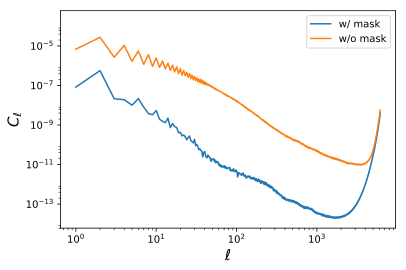

In [35]:
plt.loglog(Cl_tot, label='w/ mask')
plt.loglog(Cl_tot_nomask, label='w/o mask')
plt.legend()
plt.xlabel(r'$\ell$', size=15)
plt.ylabel(r'$C_{\ell}$', size=15)

(-0.01, 2.5)

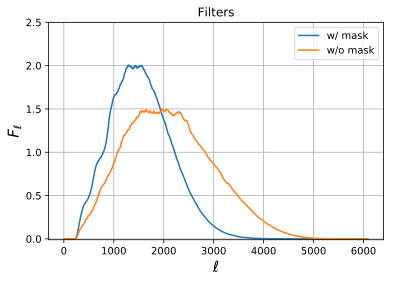

In [54]:
fwhm = np.deg2rad(4.94/60.)
sigma = fwhm/np.sqrt(8.*np.log(2))
Bl = hp.gauss_beam(fwhm, lmax=Cl_tot.size-1)
Bl_tilde = 2.*np.pi*sigma**2*Bl
ell = np.arange(Cl_tot.size)
np.sum((2.*ell+1)*Bl_tilde**2/(4.*np.pi*Cl_tot))

plt.title('Filters')
plt.plot(moving_average(1./np.sum((2.*ell+1)*Bl_tilde**2/(4.*np.pi*Cl_tot)) * Bl_tilde * filter_highpass_lowpass_1d(Cl_tot.size, lmin=300, dl=100)/Cl_tot, n=50), label='w/ mask')
plt.plot(moving_average(1./np.sum((2.*ell+1)*Bl_tilde**2/(4.*np.pi*Cl_tot_nomask)) * Bl_tilde * filter_highpass_lowpass_1d(Cl_tot.size, lmin=300, dl=100)/Cl_tot_nomask, n=50), label='w/o mask')
plt.legend()
plt.grid()
plt.xlabel(r'$\ell$', size=15)
plt.ylabel(r'$F_{\ell}$', size=15)
plt.ylim([-0.01,2.5])

In [10]:
planck_filt_ = hp.ma(planck_filt)
planck_filt_.mask = np.logical_not(mask)


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


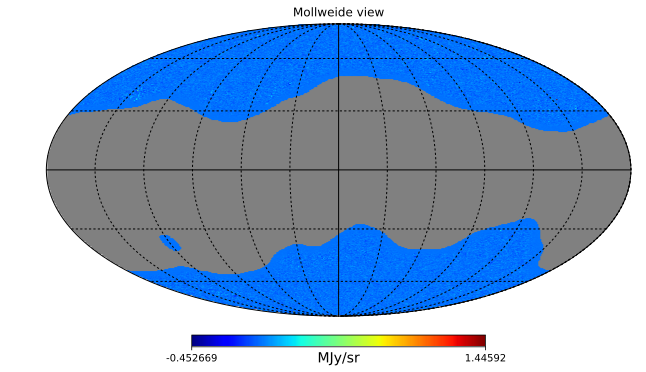

In [56]:
hp.mollview(Kcmb2MJysr(353,planck_filt_), unit='MJy/sr')
hp.graticule()

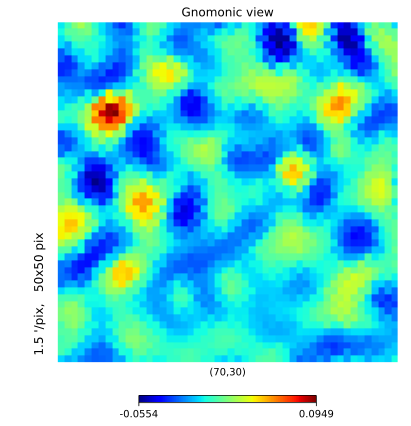

In [57]:
hp.gnomview(Kcmb2MJysr(353,planck_filt*mask), rot=[70,30], xsize=50)
plt.savefig('/Users/fbianchini/Desktop/c.pdf', bboxes_inches='tight')

In [13]:
from read_cats import GetSDSSCat

In [58]:
zbins = [(1.,5.)]#2.15)]

# Reading in QSO catalogs
qso_cat = GetSDSSCat(cats=['DR7', 'DR12'], discard_FIRST=True, z_DR12='Z_PIPE') # path_cats


In [59]:
for zmin, zmax in zbins:
    print("\t...z-bin : " + str(zmin) + " < z < " + str(zmax))
    qso = qso_cat[(qso_cat.Z >= zmin) & (qso_cat.Z <= zmax)]

    coord = SkyCoord(ra=qso.RA, dec=qso.DEC, unit='deg').transform_to('galactic')
    l = coord.l.value
    b = coord.b.value


	...z-bin : 1.0 < z < 5.0


In [146]:
# from hpyroutines.utils import Sky2Hpx, GetCountsMap
from astropy.visualization import hist

In [86]:
# Take the filtered map (in \muK) and convert to MJy/sr (see Table 6 of https://www.aanda.org/articles/aa/pdf/2014/11/aa21531-13.pdf)
planck_MJy_sr = Kcmb2MJysr(353, planck_filt) # MJy/sr
planck_mJy_sr = planck_MJy_sr * 1e9 # mJy/sr

In [95]:
# Multiply the fluxes by the area of the effective beam (in ster), see https://wiki.cosmos.esa.int/planckpla2015/index.php/Effective_Beams
planck_mJy = planck_mJy_sr * 0.0000022604304867172593 # mJy

In [109]:
display(Math(r'S_{\nu}^i = I_{\nu}^{\rm filt}(\hat{\bf{n}}_i) \times \int d\Omega \, B_{\nu}(\theta)'))

<IPython.core.display.Math object>

In [153]:
# Take the vector of fluxes and sum just the pixels *within* the mask (no pt sources so far)
pix = Sky2Hpx(l, b, 2048, coord='C') # this is basically ang2pix, i'm getting the pixels of the sources
good_pix = np.where(mask[pix]==1)
fluxes = planck_mJy[good_pix] 
rnd_pix = np.random.randint(0, hp.nside2npix(2048), fluxes.size)
fluxes_rnd = planck_mJy[np.where(mask[rnd_pix]==1)] 

In [154]:
print 'Mean of fluxes is........: %.3f mJy' %np.mean(fluxes)
print 'STD  of fluxes is........: %.3f mJy' %np.std(fluxes)
print 'STD/sqrt(n)  of fluxes is: %.3f mJy' %(np.std(fluxes)/fluxes.size**.5)

Mean of fluxes is........: 0.149 mJy
STD  of fluxes is........: 75.643 mJy
STD/sqrt(n)  of fluxes is: 0.196 mJy


In [155]:
print 'Mean of **RND** fluxes is........: %.3f mJy' %np.mean(fluxes_rnd)
print 'STD  of **RND** fluxes is........: %.3f mJy' %np.std(fluxes_rnd)
print 'STD/sqrt(n)  of **RND** fluxes is: %.3f mJy' %(np.std(fluxes_rnd)/fluxes_rnd.size**.5)

Mean of **RND** fluxes is........: -0.003 mJy
STD  of **RND** fluxes is........: 76.658 mJy
STD/sqrt(n)  of **RND** fluxes is: 0.473 mJy


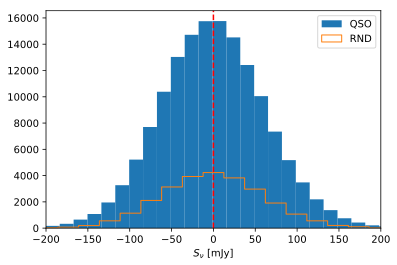

In [156]:
hist(fluxes, 'knuth', label='QSO')
hist(fluxes_rnd, 'knuth', histtype='step', label='RND')
plt.axvline(color='r', ls='--')
plt.xlim([-200,200])
plt.legend()
plt.xlabel(r'$S_{\nu}$ [mJy]')

In [158]:
b.close()

AttributeError: 'numpy.ndarray' object has no attribute 'close'